In [5]:
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *

sys.path.insert(0, 'code')
from v17 import *
from tqdm import tqdm_notebook
from models import *
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from IPython.core import debugger

In [6]:
area_id       = 5
area_id_idx   = area_id - 2
prefix        = area_id_to_prefix(area_id)
ORIGINAL_SIZE = 650
sz            = 256
num_workers   = 4
num_slice     = 25
bs            = 32

padding_sz    = 59
padded_sz     = ORIGINAL_SIZE + 2 * padding_sz

gpu_start     = 4
num_gpus      = 2
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

In [40]:
PATH                    = Path('data')
DATA_PATH               = Path('working/images/v5')
TRN                     = Path('trn_test_full_rgb')
FMT_VALTRAIN_FN         = '{}_valtrain_ImageId.csv'.format(prefix)
FMT_VALTEST_FN          = '{}_valtest_ImageId.csv'.format(prefix)
FMT_VALTRAIN_MASK_STORE = 'valtrain_{}_mask.h5'.format(prefix)
FMT_VALTEST_MASK_STORE  = 'valtest_{}_mask.h5'.format(prefix)
FMT_IMMEAN              = '{}_immean.h5'.format(prefix)

datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train',
             'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
datapath = datapaths[area_id_idx]


model_name              = 'unet'
weight_name             = [model_name + '-' + o for o in ['vegas', 'paris', 'shanghai', '5']]
weight_load             = weight_name[area_id_idx]
# weight_load             = weight_name[0]

In [8]:
valtest_csv = pd.read_csv(PATH/DATA_PATH/FMT_VALTEST_FN)
image_ids = valtest_csv['ImageId'].tolist()
# x_names = [PATH/DATA_PATH/TRN/(str(o)+'.png') for o in image_ids]
x_names = [str(o) + '.png' for o in image_ids]

In [9]:
n = valtest_csv.shape[0]
y = np.empty((n, ORIGINAL_SIZE, ORIGINAL_SIZE, 1))

with tb.open_file(str(PATH/DATA_PATH/FMT_VALTEST_MASK_STORE)) as f:
    for i, image_id in tqdm_notebook(enumerate(image_ids), total=n):
        fn = '/' + image_id
        y[i] = np.array(f.get_node(fn))[..., None]
y = np.broadcast_to(y, (n, ORIGINAL_SIZE, ORIGINAL_SIZE, 3))

In [10]:
x_names[:3]

['AOI_5_Khartoum_img152.png',
 'AOI_5_Khartoum_img221.png',
 'AOI_5_Khartoum_img1263.png']

In [11]:
class OptionalFilesArrayDataset(FilesArrayDataset):
    def __init__(self, fnames, y, transform, path, num_slice):
        self.side = int(np.sqrt(num_slice))
        assert(self.side**2 == num_slice and num_slice >= 9)
        self.num_slice = num_slice
        
        self.is_empty = (fnames == 'empty')
        if not self.is_empty:
            self.n = len(fnames) * num_slice
            padding_shape = [[0, 0], [padding_sz]*2, [padding_sz]*2, [0, 0]]
            y = np.pad(y, padding_shape, 'reflect')
            super().__init__(fnames, y, transform, path)
        else:
            self.n = 0

    def cut_im_at_pos(self, im, slice_pos):
        slice_pos %= self.num_slice
        cut_j, cut_i = divmod(slice_pos, self.side)
        stride = (padded_sz - sz) // (self.side - 1)
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
    def get_x(self, i):
        I = i // self.num_slice
        fn = self.path/self.fnames[I]
        x = self.read_cached_im(fn)
        return self.cut_im_at_pos(x, i)
    
    def get_y(self, i):
        I = i // self.num_slice
        y = self.y[I]
        return self.cut_im_at_pos(y, i)
    
    def get_c(self): return 1
    def get_n(self): return self.n
    
    @staticmethod
    @lru_cache(maxsize=500)
    def read_cached_im(fn):
        padding_shape = [[padding_sz]*2, [padding_sz]*2, [0, 0]]
        im = open_image(fn)
        return np.pad(im, padding_shape, 'reflect')

In [12]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(str(PATH/DATA_PATH/FMT_IMMEAN), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    mean = im_mean.mean(axis=(1, 2))
    std = imagenet_stats[1]
    return mean, std

stats = get_rgb_mean_stat(area_id)
aug_tfms = transforms_top_down
for o in aug_tfms: o.tfm_y = TfmType.CLASS
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
empty = ['empty'] * 2
datasets = ImageData.get_ds(OptionalFilesArrayDataset, empty, empty, tfms,
                            test=(x_names, y), path=PATH/DATA_PATH/TRN, num_slice=num_slice)
md = ImageData(str(PATH), datasets, bs, num_workers=num_workers, classes=None)
denorm = md.test_ds.denorm

In [13]:
class UpsampleModel():
    def __init__(self, model, cut_base=8, name='upsample'):
        self.model,self.name = model,name
        self.cut_base = cut_base

    def get_layer_groups(self, precompute):
        c = children(self.model.module)
        return [c[:self.cut_base],
                c[self.cut_base:]]

model = to_gpu(UNet16(pretrained='vgg'))
cut_base = 8
model = nn.DataParallel(model, device_ids=device_ids)
model = UpsampleModel(model, cut_base=cut_base)

# MODEL                   = PATH/'models'/weight_name[area_id_idx]
# model.load_state_dict(state_dict = torch.load(str(MODEL) + '.h5', map_location=lambda storage, loc: storage))

In [41]:
learn = ConvLearner(md, model)
learn.load(weight_load)

In [42]:
x, y = learn.data.test_dl.get_batch(range(32))
preds = to_np(learn.model(V(x))).squeeze()
x_denorm = denorm(x)

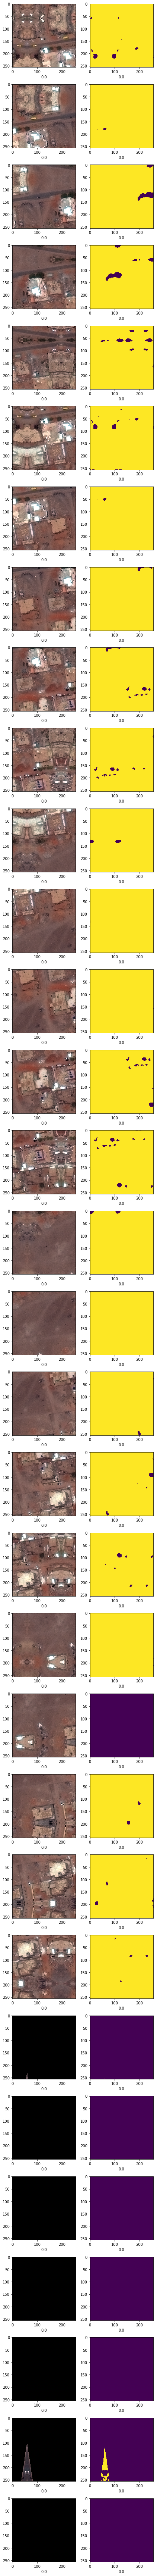

In [43]:
im_data = zip(x_denorm, preds>0.5)
plot_ims(im_data)

In [60]:
%%time
preds = learn.predict(is_test=True)
preds = preds.squeeze()

CPU times: user 27min 8s, sys: 2min 11s, total: 29min 19s
Wall time: 48.2 s


In [20]:
def plot_ims(data, labels=None, figsize=3):
    # data and labels should be zips
    data = list(data)
    n_ims = len(data)
    cols = len(list(zip(*data)))
    if labels is not None:
        labels = list(labels)
    else:
        labels = np.zeros((n_ims, cols))
    fig, ax = plt.subplots(n_ims, cols, figsize=(figsize*cols, figsize*n_ims))
    for i, row in enumerate(ax):
        if len(ax.shape) == 1:
            row.imshow(data[0][i])
            row.set_xlabel(labels[0][i])
        else:
            for j, col in enumerate(row):
                col.imshow(data[i][j])
                col.set_xlabel(labels[i][j])
    fig.tight_layout()

In [30]:
denorm(b[0][:4]).shape

(4, 256, 256, 3)

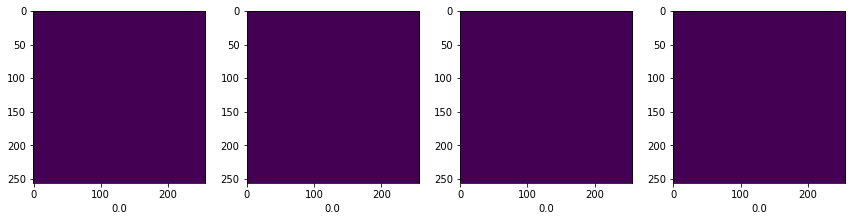

In [35]:
plot_ims([(preds[:4]>0.5)])

In [38]:
def crop_center(im, padding_sz):
    return im[padding_sz:-padding_sz,
              padding_sz:-padding_sz]

def put_back_slices(ims):
    # ims.shape --> (num_slice, length, hight, channels)
    num_slice = ims.shape[0]
    side = int(np.sqrt(num_slice))
    assert(side**2 == num_slice and num_slice >= 9)
    assert(ims.shape[-1] < 10)
#     debugger.set_trace()
    
    final_shape = [padded_sz, padded_sz, ims.shape[-1]]
    final = np.empty(final_shape)
    count = np.zeros(final_shape[:2] + [1])
    for slice_pos, im in enumerate(ims):
        pos_j, pos_i = divmod(slice_pos, side)
        stride = (padded_sz - sz) // (side - 1)
        # naming error: x and y should be swapped
        # for numpy, y comes first
        # but for consistancy, ignore for now
        x = int(stride * pos_j)
        y = int(stride * pos_i)
        
#         debugger.set_trace()
        final[x:x+sz, y:y+sz] += im
        count[x:x+sz, y:y+sz] += 1
#     debugger.set_trace()
    final /= count
    return crop_center(final, padding_sz)

In [40]:
def put_back_parallel(preds, num_slice):
    # Create batches
    preds = preds.squeeze()[..., None]
    batches = np.split(preds, preds.shape[0] // num_slice)
    
    # No external calls. Use multiprocessing
#     return map(put_back_slices, batches)
#     with ProcessPoolExecutor(max_workers=num_workers) as e:
    with ThreadPoolExecutor(max_workers=num_workers) as e:
        return e.map(put_back_slices, batches)

In [56]:
%%time
start = 50
n = 4
t = put_back_parallel(preds[start*num_slice:(start+n)*num_slice], num_slice)
t = [o.squeeze() for o in t]

CPU times: user 109 ms, sys: 25.6 ms, total: 134 ms
Wall time: 30.2 ms


In [ ]:
# %debug

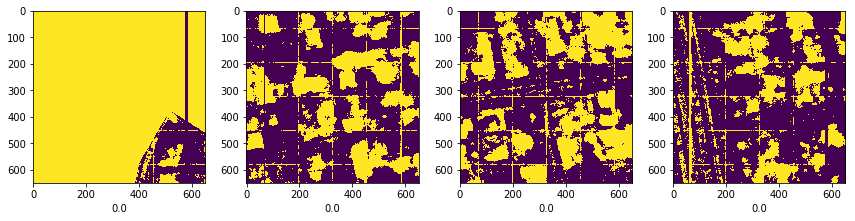

In [57]:
plot_ims([[o>0.5 for o in t]])

In [ ]:
preds_crop = [preds.squeeze()]
preds_scale = []
fscores, prs, y_pred = evalfscore(datapath, preds_crop, preds_scale,
                                  debug=False, num_slice=num_slice)

# Training

In [4]:
valtest_csv = pd.read_csv(PATH/DATA_PATH/FMT_VALTEST_FN)
image_ids = valtest_csv['ImageId'].tolist()
# x_names = [PATH/DATA_PATH/TRN/(str(o)+'.png') for o in image_ids]
x_names = [str(o) + '.png' for o in image_ids]

In [4]:
valtest_csv = pd.read_csv(PATH/DATA_PATH/FMT_VALTEST_FN)
image_ids = valtest_csv['ImageId'].tolist()
# x_names = [PATH/DATA_PATH/TRN/(str(o)+'.png') for o in image_ids]
x_names = [str(o) + '.png' for o in image_ids]

In [5]:
n = valtest_csv.shape[0]
y = np.empty((n, ORIGINAL_SIZE, ORIGINAL_SIZE, 1))

with tb.open_file(str(PATH/DATA_PATH/FMT_VALTEST_MASK_STORE)) as f:
    for i, image_id in tqdm_notebook(enumerate(image_ids), total=n):
        fn = '/' + image_id
        y[i] = np.array(f.get_node(fn))[..., None]
y = np.broadcast_to(y, (n, ORIGINAL_SIZE, ORIGINAL_SIZE, 3))

In [6]:
x_names[:3]

['AOI_5_Khartoum_img152.png',
 'AOI_5_Khartoum_img221.png',
 'AOI_5_Khartoum_img1263.png']